# Visualize profiling results
## 1. concat profile results and dcgm results 

In [ ]:
from typing import Union
import pandas as pd
import numpy as np
from pathlib import Path


def timestamps_align(record_file_path: Union[str, Path], dcgm_file_path: Union[str, Path]):
    res = pd.read_csv(record_file_path)
    dcgm = pd.read_csv(dcgm_file_path)
    for index in range(len(res)):
        time_period = [int(res.loc[index, 'start_timestamp']), int(res.loc[index, 'end_timestamp'])]
        gract = []
        fb_used = []
        for i in range(len(dcgm)):
            if int(dcgm.loc[i, 'TimeStamp']) > time_period[1]:
                break
            if time_period[1] >= int(dcgm.loc[i, 'TimeStamp']) >= time_period[0]:
                gract += [float(dcgm.loc[i, 'GRACT'])]
                fb_used += [float(dcgm.loc[i, 'FBUSD'])]
        gract_mean = 0.0 if gract == [] else np.mean(gract)
        gract_std = 0.0 if gract == [] else np.std(gract)
        fb_used_mean = 0.0 if fb_used == [] else np.mean(fb_used)
        fb_used_std = 0.0 if fb_used == [] else np.std(fb_used)
        res.loc[index, 'gract_mean'] = round(gract_mean, 3)
        res.loc[index, 'gract_std'] = round(gract_std, 3)
        res.loc[index, 'fb_used_mean'] = round(fb_used_mean, 3)
        res.loc[index, 'fb_used_std'] = round(fb_used_std, 3)
    save_file = Path(record_file_path).parent / 'integrated_result.csv'
    res.to_csv(save_file)

In [16]:
timestamps_align("E:\MIGProfiler\data\A100-80g\infer\cv\cv_infer.csv", "E:\MIGProfiler\data\A100-80g\infer\cv\dcgm.csv")
timestamps_align("E:\MIGProfiler\data\A100-80g\infer\nlp\nlp_infer_seq.csv", "E:\MIGProfiler\data\A100-80g\infer\nlp\dcgm.csv")

## 2. plot pictures

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from matplotlib.backends.backend_pgf import FigureCanvasPgf

mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
pd.set_option('display.max_columns', None)
WIDTH = 506.295
MARKER_LIST = ['.', '*', '^', 'p', 'o', 'x']
HATCH_LIST = [None, '\\', 'x', '-', '/', '+']
COLOR_LIST = ['#DC143C', '#8B008B', '#6495ED', '#3CB371', '#FFD700', '#F08080', '#FF8C00', '#008B8B', '#7B68EE']
short_name = {
        'distiluse-base-multilingual-cased-v1': "distil_v1",
        'distiluse-base-multilingual-cased-v2': "distil_v2",
        'paraphrase-multilingual-MiniLM-L12-v2': "MiniLM",
        'paraphrase-multilingual-mpnet-base-v2': "mpnet",
        'bert-base': "bert-base",
        'resnet50': 'resnet50',
        'vision_transformer': 'vision_transformer'
    }


def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** .5 - 1) / 1.5

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)
    #     fig_dim = (2*fig_width_in, fig_height_in)

    return fig_dim


def set_style():
    plt.style.use('classic')

    nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 19,
        "font.size": 16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    }

    mpl.rcParams.update(nice_fonts)


def my_plotter(legends, means_list, x_labels, title, y_axis_name, x_axis_name, save_path, legend_pos, barlabel_fmt, std_list=None):
    fig, ax = plt.subplots(1, 1, figsize=set_size(WIDTH))
    y_limit = float(max([max(means) for means in means_list]))*1.4
    index = np.arange(len(x_labels), step=1)
    ax.plot()
    for i, legend in enumerate(legends):
        if i < len(means_list):
            if std_list is None:
                bar = ax.bar(index + 0.2 * i - 0.3, means_list[i], color=COLOR_LIST[i], label=str(legend) , width=0.15)
            else:
                bar = ax.bar(index+0.2*i-0.3, means_list[i], yerr=std_list[i], color=COLOR_LIST[i], label=legend, width=0.15)
            ax.bar_label(bar, label_type='edge', fmt=barlabel_fmt, fontsize=4)

    plt.margins(x=0.08)
    
    ax.set_xlabel(x_axis_name, fontsize=16)
    ax.set_ylabel(y_axis_name, fontsize=16)
    ax.set_ylim([0, y_limit])

    ax.tick_params(axis='x', rotation=0)
    ax.set_xticks(index)
    ax.set_xticklabels(x_labels, fontsize=14)

    yticks = ax.yaxis.get_major_ticks()
    yticks[0].label1.set_visible(False)
    yticks[1].label1.set_visible(False)

    ax.legend(loc=legend_pos, ncol=2, fontsize=13)
    plt.title(title, fontsize=13)
    plt.tight_layout()
    plt.savefig(save_path, format='svg')
    plt.close()

### 1> draw pictures for batch size comparison

In [23]:
def bsz_draw(result: pd.DataFrame, picture_dir):

    for model_name, model_group in result.groupby('model_name'):
        instances = []
        latency_list = []
        latency_std_list = []
        throughput_list = []
        gract_list = []
        gract_std_list = []
        fbusd_list = []
        fbusd_std_list = []
        for instance, model_instance_group in model_group.groupby('mig_profile'):
            instances += [str(instance)]
            latency_list += [model_instance_group.loc[:, 'latency']]
            latency_std_list += [model_instance_group.loc[:, 'latency_std']]
            throughput_list += [model_instance_group.loc[:, 'throughput']]
            gract_list += [model_instance_group.loc[:, 'gract_mean']]
            gract_std_list += [model_instance_group.loc[:, 'gract_std']]
            fbusd_list += [model_instance_group.loc[:, 'fb_used_mean']]
            fbusd_std_list += [model_instance_group.loc[:, 'fb_used_std']]

        my_plotter(
            legends=instances,
            means_list=fbusd_list,
            x_labels=model_instance_group.loc[:, 'batch_size'],
            title=model_name,
            x_axis_name="batch size",
            y_axis_name="FB used",
            save_path=f"{picture_dir}/{short_name[model_name]}_fbusd_bsz_compare.svg",
            legend_pos='upper right',
            barlabel_fmt='%.0f'
        )
        my_plotter(
            legends=instances,
            means_list=gract_list,
            std_list=gract_std_list,
            title=model_name,
            x_labels=model_instance_group.loc[:, 'batch_size'],
            x_axis_name="batch size",
            y_axis_name="Graphics Engine Activity",
            save_path=f"{picture_dir}/{short_name[model_name]}_gract_bsz_compare.svg",
            legend_pos='upper right',
            barlabel_fmt='%.2f'
        )
        my_plotter(
            legends=instances,
            means_list=latency_list,
            std_list=latency_std_list,
            title=model_name,
            x_labels=model_instance_group.loc[:, 'batch_size'],
            x_axis_name="batch size",
            y_axis_name="latency(ms)",
            save_path=f"{picture_dir}/{short_name[model_name]}_latency_bsz_compare.svg",
            legend_pos='upper right',
            barlabel_fmt='%.0f'
        )
        my_plotter(
            legends=instances,
            means_list=throughput_list,
            title=model_name,
            x_labels=model_instance_group.loc[:, 'batch_size'],
            x_axis_name="batch size",
            y_axis_name="throughput(/s)",
            save_path=f"{picture_dir}/{short_name[model_name]}_throughput_bsz_compare.svg",
            legend_pos='upper right',
            barlabel_fmt='%.0f'
        )

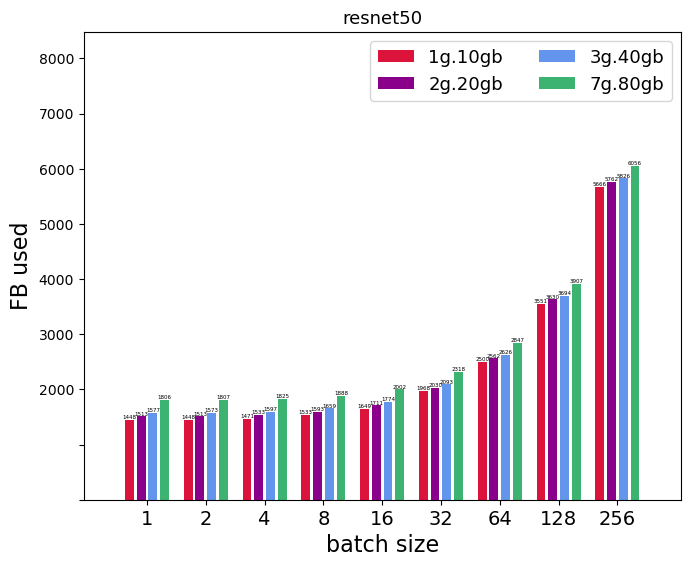

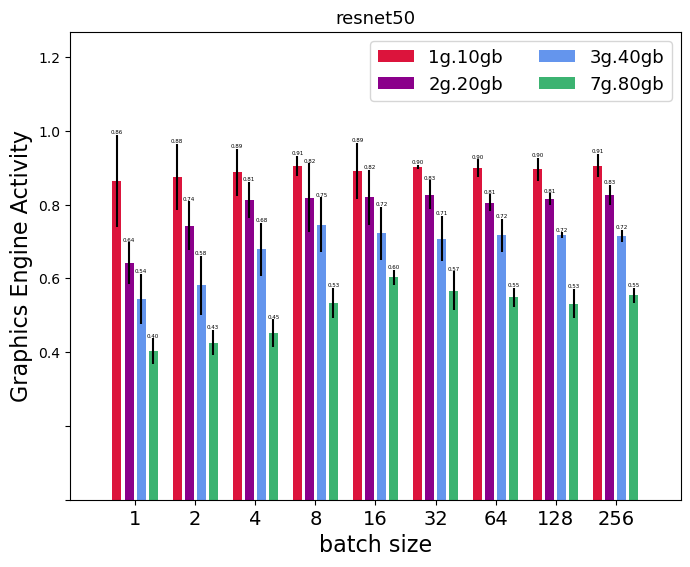

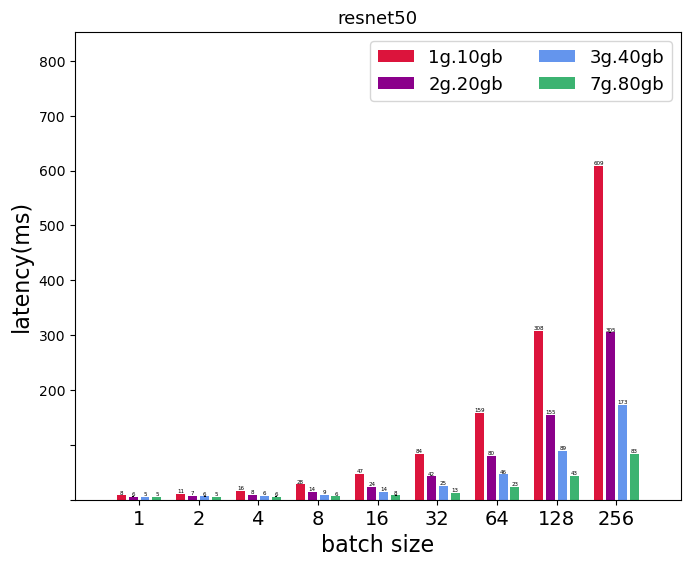

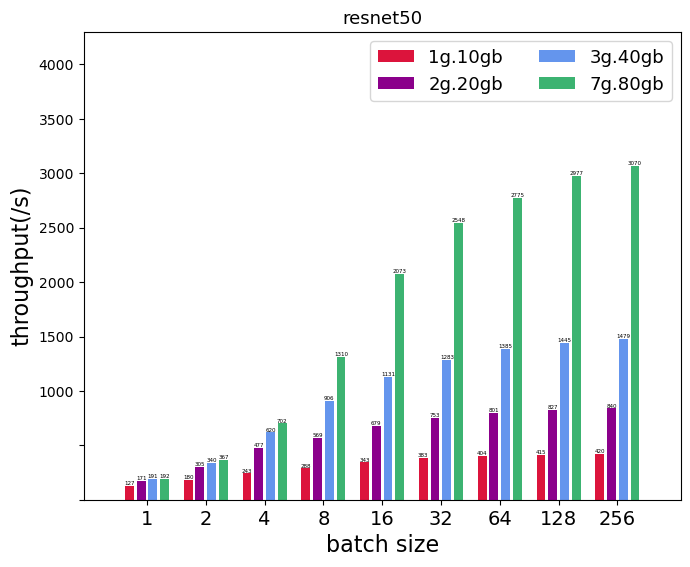

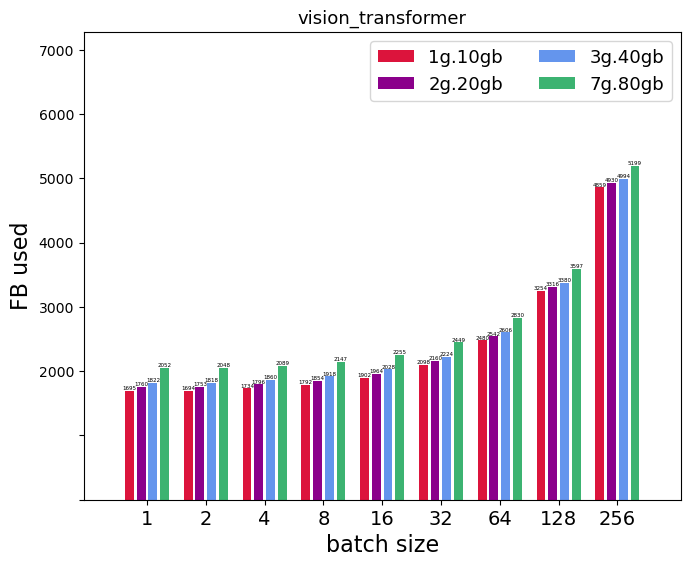

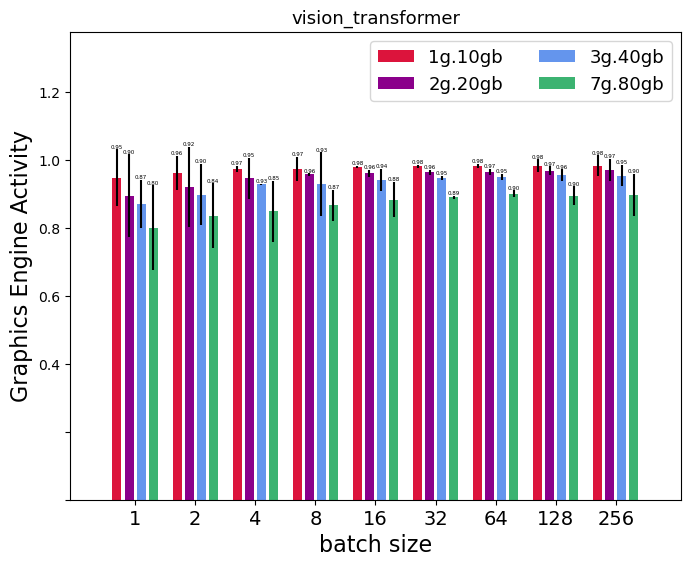

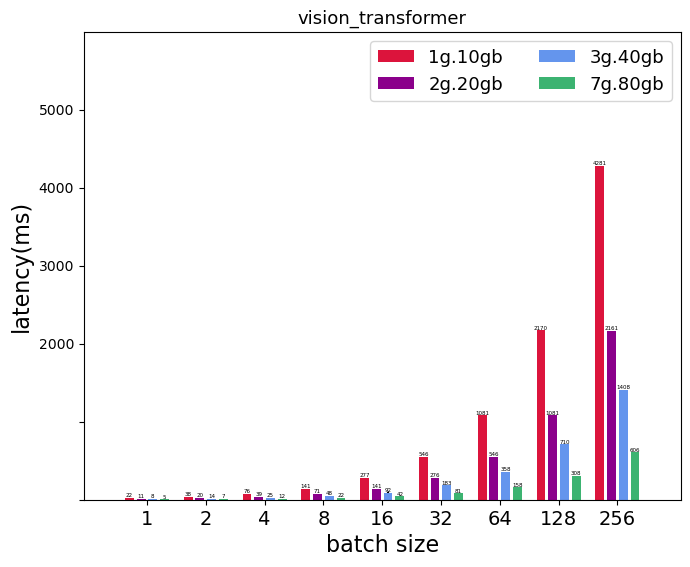

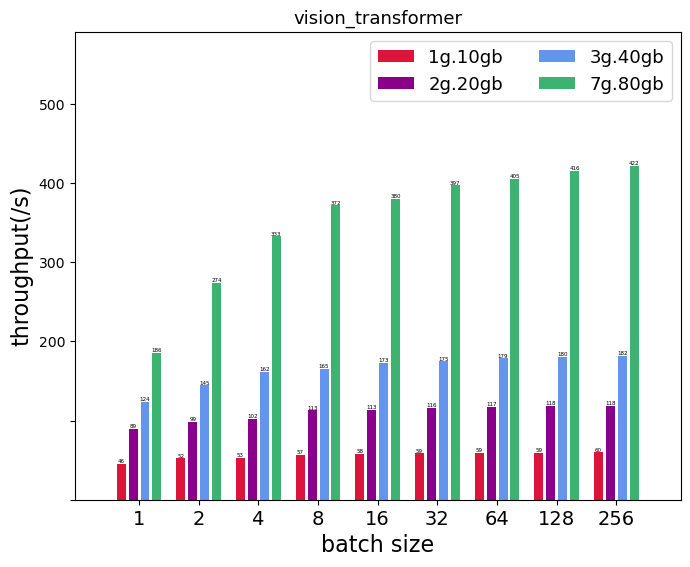

In [30]:
result = pd.read_csv('E:/MIGProfiler/data/A100-80g/infer/cv/integrated_result.csv')
bsz_draw(result, "E:/MIGProfiler/data/A100-80g/infer/cv/")

### 2> draw pictures for sequence length comparison

In [25]:

def seq_draw(result: pd.DataFrame, picture_dir):
    for model_name, model_group in result.groupby('model_name'):
        instances = []
        latency_list = []
        latency_std_list = []
        throughput_list = []
        gract_list = []
        gract_std_list = []
        fbusd_list = []
        fbusd_std_list = []
        for instance, model_instance_group in model_group.groupby('mig_profile'):
            instances += [str(instance)]
            latency_list += [model_instance_group.loc[:, 'latency']]
            latency_std_list += [model_instance_group.loc[:, 'latency_std']]
            throughput_list += [model_instance_group.loc[:, 'throughput']]
            gract_list += [model_instance_group.loc[:, 'gract_mean']]
            gract_std_list += [model_instance_group.loc[:, 'gract_std']]
            fbusd_list += [model_instance_group.loc[:, 'fb_used_mean']]
            fbusd_std_list += [model_instance_group.loc[:, 'fb_used_std']]

        my_plotter(
            legends=instances,
            means_list=fbusd_list,
            x_labels=model_instance_group.loc[:, 'seq_length'],
            title=model_name,
            x_axis_name="sequence length",
            y_axis_name="FB used",
            save_path=f"{picture_dir}/{short_name[model_name]}_fbusd_seq_compare.svg",
            legend_pos='upper right',
            barlabel_fmt='%.0f'
        )
        my_plotter(
            legends=instances,
            means_list=gract_list,
            std_list=gract_std_list,
            title=model_name,
            x_labels=model_instance_group.loc[:, 'seq_length'],
            x_axis_name="sequence length",
            y_axis_name="Graphics Engine Activity",
            save_path=f"{picture_dir}/{short_name[model_name]}_gract_seq_compare.svg",
            legend_pos='upper right',
            barlabel_fmt='%.2f'
        )
        my_plotter(
            legends=instances,
            means_list=latency_list,
            std_list=latency_std_list,
            title=model_name,
            x_labels=model_instance_group.loc[:, 'seq_length'],
            x_axis_name="sequence length",
            y_axis_name="latency(ms)",
            save_path=f"{picture_dir}/{short_name[model_name]}_latency_seq_compare.svg",
            legend_pos='upper right',
            barlabel_fmt='%.0f'
        )
        my_plotter(
            legends=instances,
            means_list=throughput_list,
            title=model_name,
            x_labels=model_instance_group.loc[:, 'seq_length'],
            x_axis_name="sequence length",
            y_axis_name="throughput(/s)",
            save_path=f"{picture_dir}/{short_name[model_name]}_throughput_seq_compare.svg",
            legend_pos='upper right',
            barlabel_fmt='%.0f'
        )

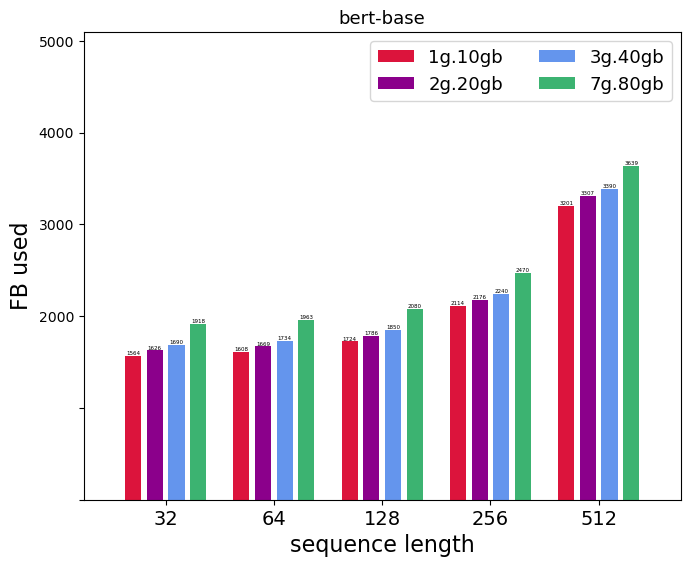

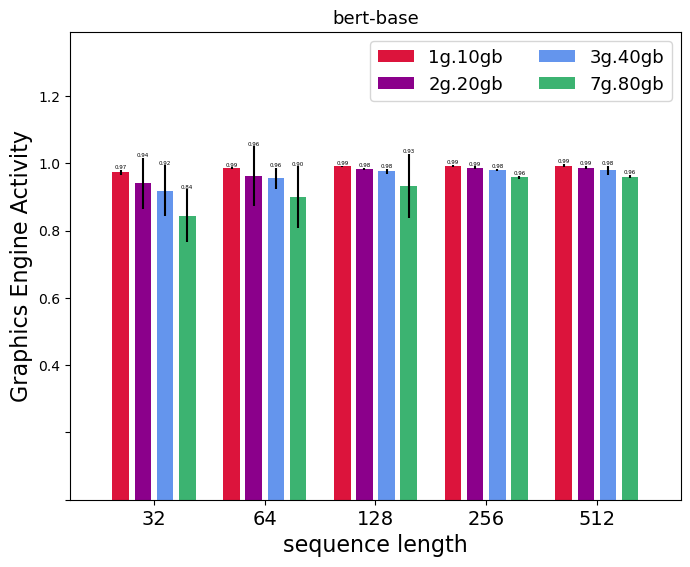

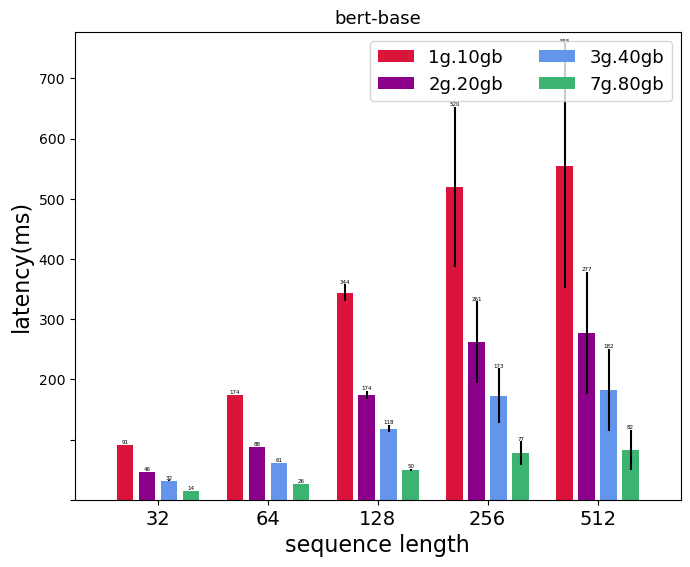

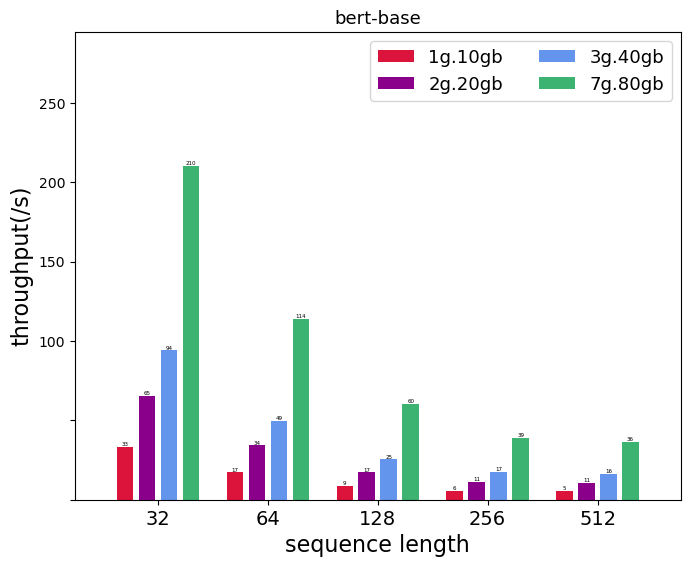

In [29]:
result = pd.read_csv('E:/MIGProfiler/data/A100-80g/infer/nlp/integrated_result_seq.csv')
seq_draw(result, "E:/MIGProfiler/data/A100-80g/infer/nlp")